# Self-Driving Car Engineer Nanodegree

## Advanced Lane Finding Project
---

The goals / steps of this project are the following:
1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images. 
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## [Rubric](https://review.udacity.com/#!/rubrics/476/view) Points
---

## Helper Functions

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Polygon
import numpy as np
import glob

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

# list of test images' paths
test_in_paths = glob.glob('test_images/*')


def plot_result(imgs, names, rows=0, cols=0, save=False):  # 저장 기능 추가
    '''
    plot the result
    '''
    if (len(imgs)==0 or len(names)==0): 
        return -1
    
    f, ax = plt.subplots(rows, cols, figsize=(16,8))
    f.tight_layout()
    i = 0
    if rows <= 1 :
        for c in range(cols):
            ax[c].imshow(imgs[i], cmap='gray')
            ax[c].set_title('{}'.format(names[i]), fontsize=24)
            ax[c].axis('off')
            i += 1
    else:
        for r in range(rows):
            for c in range(cols):
                ax[r, c].imshow(imgs[i], cmap='gray')
                ax[r, c].set_title('{}'.format(names[i]), fontsize=24)
                ax[r, c].axis('off')
                i += 1
    plt.suptitle(p.split('/')[-1], fontsize=36)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    if save:
        print(f"{p.split('/')[-1]}plot.jpg")
        plt.savefig(f"plot/{p.split('/')[-1]}-plot.jpg")
    


def camera_calibration(cal_path, debug=False):
    '''
    this routine performs camera calibration
    it returns `mtx` and `dist` needed to
    undistort images taken from this camera
    '''
    # list all calibration images paths
    cal_images_names = glob.glob(cal_path)

    # chessboard-specific parameters
    nx = 10
    ny = 7

    # code below is based on classroom example
    objpoints = [] # 3D points
    imgpoints = [] # 2D points

    # (x,y,z): (0,0,0), (1,0,0), etc
    objp = np.zeros((nx * ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates, z stays 0

    for fname in cal_images_names:
        # read in image
        img = cv2.imread(fname)

        # convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # find chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # in case chessboard was found successfully
        if ret == True:
            # image points will be different for each calibration image
            imgpoints.append(corners)
            # object points are the same for all calibration images
            objpoints.append(objp)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            if debug:
                print(fname)
                cv2.imwrite(f'{fname[:-4]}-r.jpg', img)  # 테스트로 추가
                
                plt.figure(figsize=(15,10))
                plt.imshow(img)

    # calibration parameters calculation
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    # will only use `mtx` and `dist` in this project, hence return
    return mtx, dist

def undistort_image(image, mtx, dist):
    '''
    returns an undistorted image (after camera calibration)
    '''
    dst = cv2.undistort(image, mtx, dist, None, mtx)

    return dst

def gaussian_blur(image, kernel=5):
    '''
    this routine applies blur to reduce noise in images
    '''
    blurred = cv2.GaussianBlur(image, (kernel,kernel), 0)
    return blurred


def get_thresholded_image(img):
    
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    height, width = gray.shape
    
    # # apply gradient threshold on the horizontal gradient
    # sx_binary = abs_sobel_thresh(gray, 'x', 10, 200)
    # 
    # # apply gradient direction threshold so that only edges closer to vertical are detected.
    # dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    # 
    # # combine the gradient and direction thresholds.
    # combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    # 
    # # R & G thresholds so that yellow lanes are detected well.
    # color_threshold = 100  # 150
    # R = img[:,:,0]
    # G = img[:,:,1]
    # color_combined = np.zeros_like(R)
    # r_g_condition = (R > color_threshold) & (G > color_threshold)
    # 
    # 
    # # color channel thresholds
    # hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # S = hls[:,:,2]
    # L = hls[:,:,1]
    # 
    # # S channel performs well for detecting bright yellow and white lanes
    # s_thresh = (100, 255)
    # s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    # 
    # # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    # l_thresh = (120, 255)
    # l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])
    # 
    # # combine all the thresholds
    # # A pixel should either be a yellowish or whiteish
    # # And it should also have a gradient, as per our thresholds
    # color_combined[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1
    # apply gradient threshold on the horizontal gradient
    sx_binary = abs_sobel_thresh(gray, 'x', 10, 200)
    
    # apply gradient direction threshold so that only edges closer to vertical are detected.
    # dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/3))
    
    # combine the gradient and direction thresholds.
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 100
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]  # Hue channel
    S = hls[:,:,2]  # Saturation channel
    L = hls[:,:,1]  # Lightness channel
    
    # Adjust the H channel for yellow
    h_thresh = (15, 30)  # Hue values for yellowish colors
    h_condition = (H > h_thresh[0]) & (H <= h_thresh[1])
    
    # S channel performs well for detecting bright yellow and white lanes
    s_thresh = (90, 255)  # slightly adjust the lower bound for better yellow detection
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    
    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])
    
    # combine all the thresholds
    color_combined[((r_g_condition & l_condition) & s_condition) | (h_condition & s_condition) | combined_condition] = 1

    
    # apply the region of interest mask
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)
    
    return thresholded
 
    
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    max_value = np.max(abs_sobel)
    binary_output = np.uint8(255*abs_sobel/max_value)
    threshold_mask = np.zeros_like(binary_output)
    threshold_mask[(binary_output >= thresh_min) & (binary_output <= thresh_max)] = 1
    return threshold_mask

# def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
def dir_threshold(gray, sobel_kernel=21, thresh=(np.pi/3, np.pi/2)):
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobel_y,abs_sobel_x)
    direction = np.absolute(direction)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros_like(direction)
    mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mask



def warp(img, src_coordinates=None, dst_coordinates=None):

    # Define calibration box in source (original) and destination (desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])
    
    
    if src_coordinates is None:
        src_coordinates = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right
        
    if dst_coordinates is None:
        dst_coordinates = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right   

    # Compute the perspective transfor, M
    M = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)

    
    # Compute the inverse perspective transfor also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst_coordinates, src_coordinates)
    
    # Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv


## 1. Camera Calibration

1. Have the camera matrix and distortion coefficients been computed correctly and checked on one of the calibration images as a test?
The code for this step is contained in the first code cell of the IPython notebook (or in lines # through # of the file called some_file.py ).
I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image. Thus, objp is just a replicated array of coordinates, and objpoints will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.
imgpoints will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.
                
  I then used the output objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function. I applied this distortion correction to the test image using the cv2.undistort() function and obtained this result:

In [2]:
# camera calibration step

mtx, dist = camera_calibration('./cali/cal*.jpg', debug=False)

## 2. Apply a distortion correction to raw images.



test-vid2-frame2.jpgplot.jpg


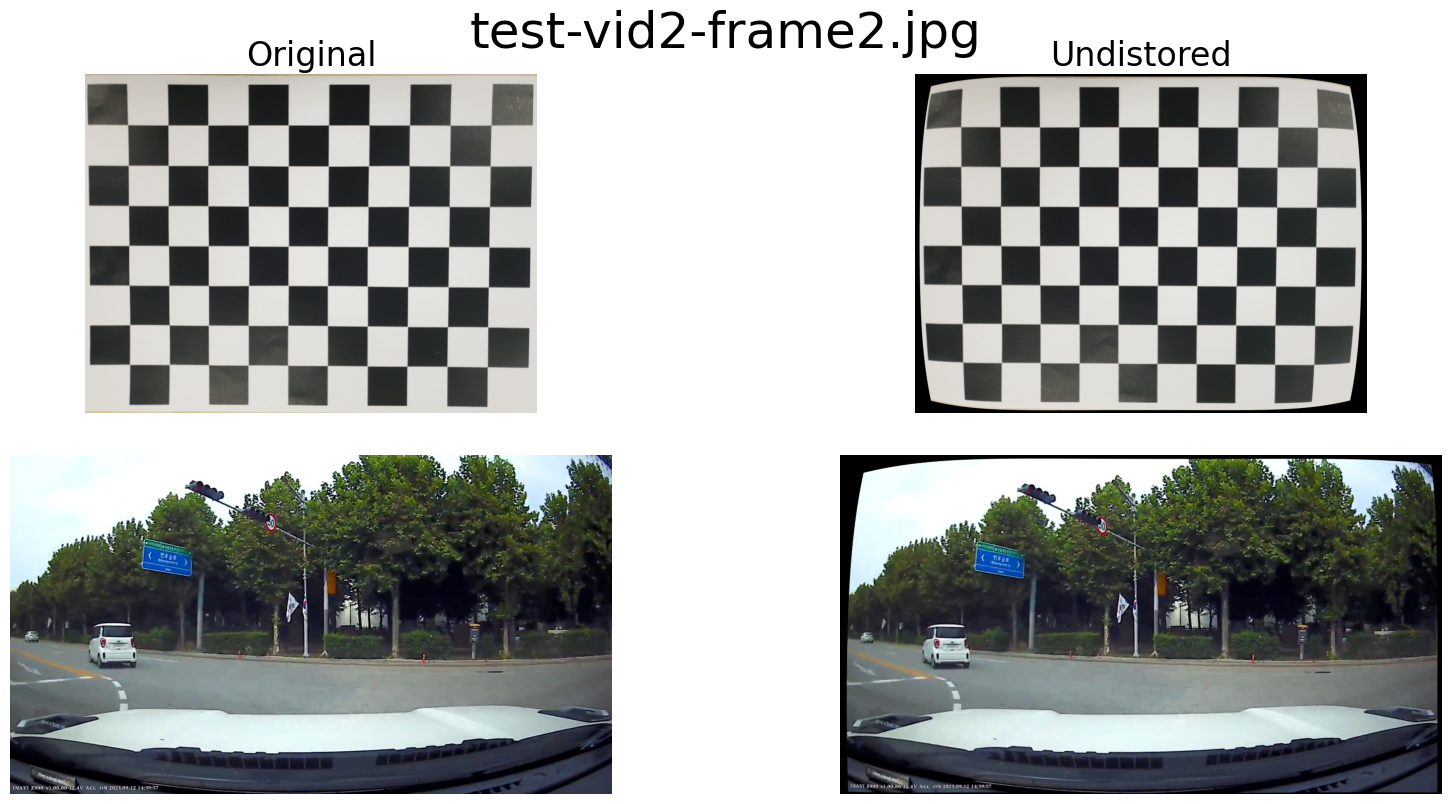

In [143]:

# Raw Test image
# p = test_in_paths[5]
p = 'test-vid2-frame2.jpg'
image = mpimg.imread(p)

# camera calibration raw image
ca_img = mpimg.imread('cali/cal1.jpg')
undistorted_ca = undistort_image(ca_img, mtx, dist)

# STEP 1: UNDISTORT (using camera calibration step matrix and dist)
undistorted = undistort_image(image, mtx, dist)


# Plot the result
imgs = [ca_img, undistorted_ca, image, undistorted]
names = ['Original' ,'Undistored','','']
plot_result(imgs, names, 2, 2, save=True)


## 3. Use color transforms, gradients, etc., to create a thresholded binary image.
### Let's have a look at different color space configurations of challenging frames
Gradient & Color Thresholding

The lanes lines in the challenge and harder challenge videos were extremely difficult to detect. They were either too bright or too dull. This prompted me to have R & G channel thresholding and L channel thresholding

True

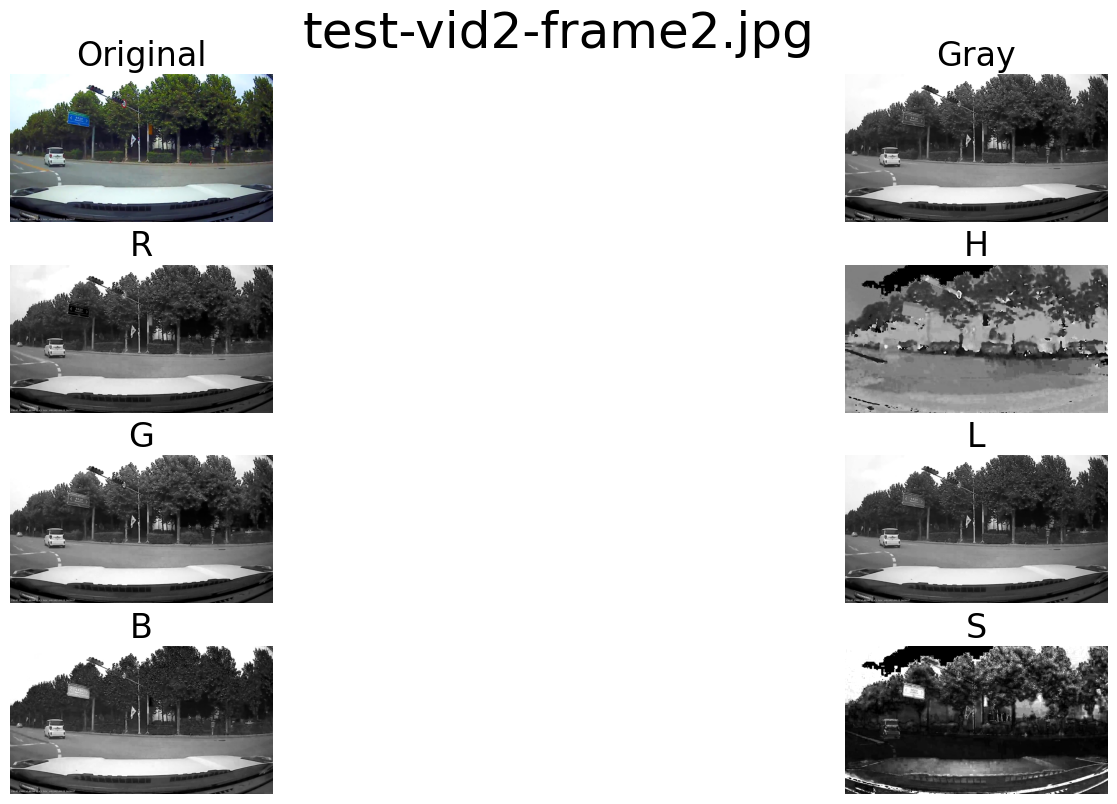

In [144]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

red = image[:,:,0]
green = image[:,:,1]
blue = image[:,:,2]
    
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
h = hls[:,:,0]
l = hls[:,:,1]
s = hls[:,:,2]
    
# Plot the result

imgs = [image, gray, red, h, green, l, blue, s]
names = ['Original', 'Gray' ,'R', 'H', 'G', 'L', 'B', 'S']
plot_result(imgs, names, 4, 2)

cv2.imwrite('plot/1.jpg', image)
cv2.imwrite('plot/2.jpg', gray)
cv2.imwrite('plot/3.jpg', red)
cv2.imwrite('plot/4.jpg', h)
cv2.imwrite('plot/5.jpg', green)
cv2.imwrite('plot/6.jpg', l)
cv2.imwrite('plot/7.jpg', blue)
cv2.imwrite('plot/8.jpg', s)

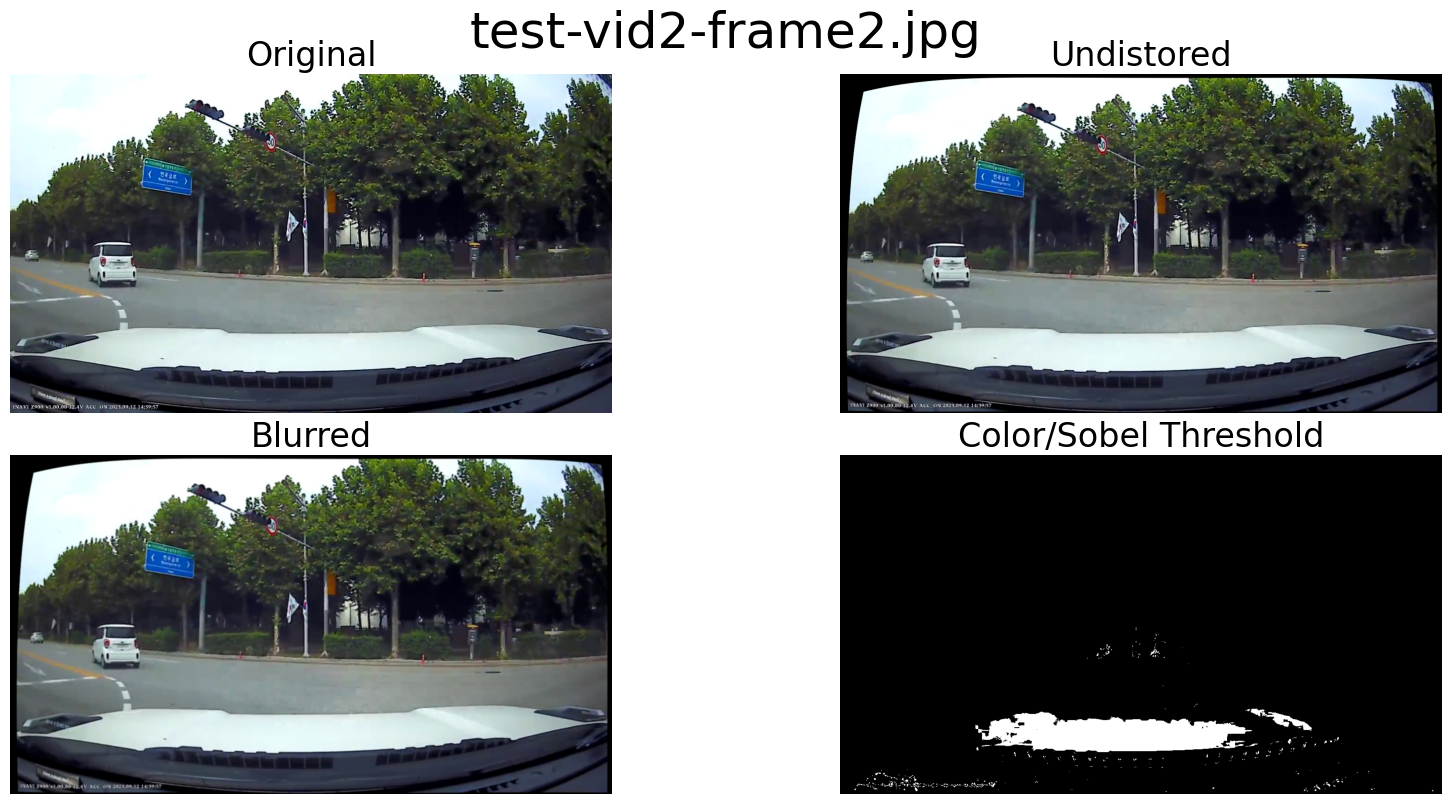

In [145]:
# STEP 2: GAUSSIAN BLUR
blurred = gaussian_blur(undistorted, kernel=3)
# STEP 3: APPLY COLOR SPACE TRANSFORM AND SOBEL THRESHOLDING
combined = get_thresholded_image(blurred)

# Plot the result
imgs = [image, undistorted, blurred, combined]
names = ['Original' ,'Undistored', 'Blurred', 'Color/Sobel Threshold']
plot_result(imgs, names, 2, 2)

# image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
# undistorted2 = cv2.cvtColor(undistorted, cv2.COLOR_RGB2BGR)
# blurred2 = cv2.cvtColor(blurred, cv2.COLOR_RGB2BGR)
# combined2 = cv2.cvtColor(combined, cv2.COLOR_RGB2BGR)
# cv2.imwrite('plot/1.jpg', image_bgr)
# cv2.imwrite('plot/2.jpg', undistorted2)
# cv2.imwrite('plot/3.jpg', blurred2)
# cv2.imwrite('plot/4.jpg', combined2 * 255)

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").
The code for my perspective transform is includes a function called warper(). The warper() function takes as inputs an image ( img ), as well as source ( src ) and destination ( dst ) points. 

True

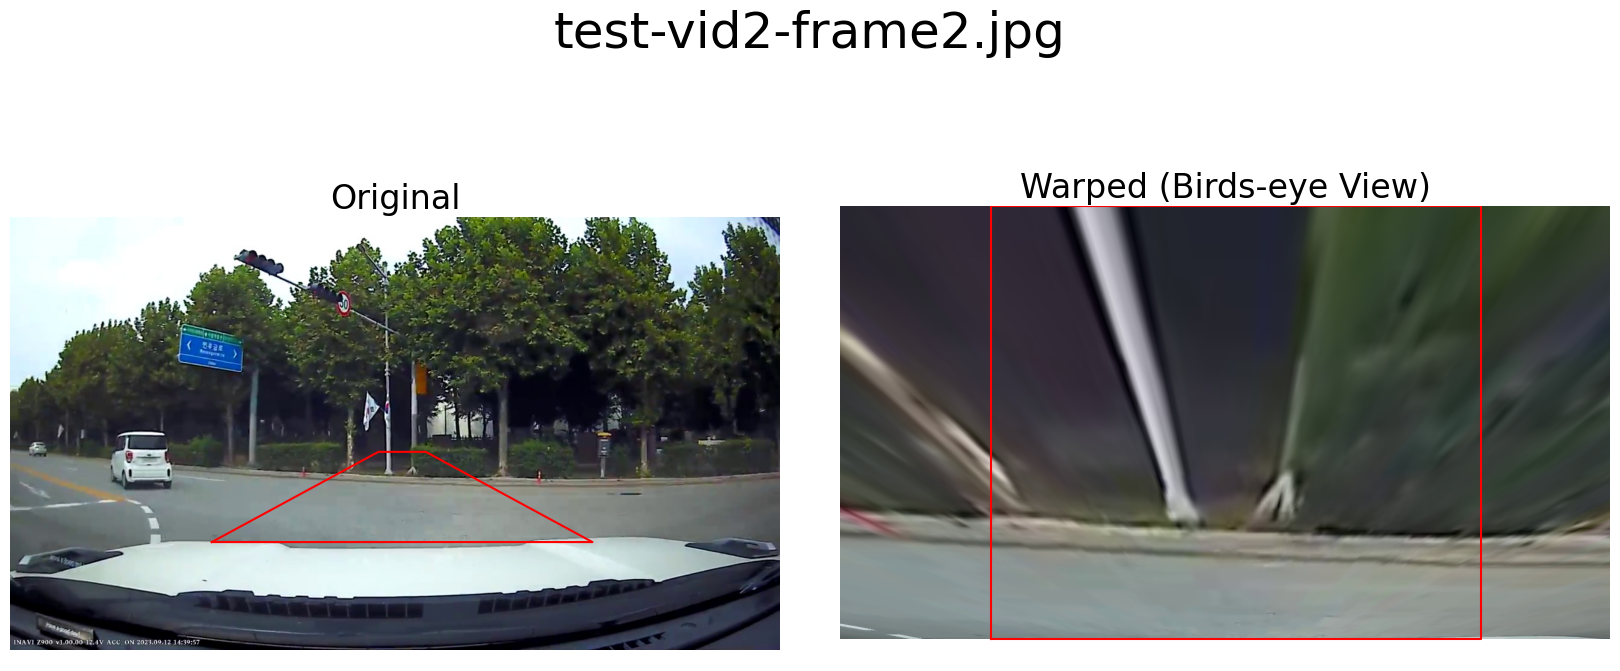

In [146]:
# Run the function



# original code
# src_coordinates = np.float32(
#     [[280,  700],  # Bottom left
#      [595,  460],  # Top left
#      [725,  460],  # Top right
#      [1125, 700]]) # Bottom right

dst_coordinates = np.float32(
    [[250,  720],  # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]]) # Bottom right   
src_coordinates = np.float32(
    [[335, 540],  # Bottom left
     [612, 390],  # Top left
     [691, 390],  # Top right
     [968, 540]]) # Bottom right

# src_coordinates = np.float32(
#     [[440, 540],  # Bottom left
#      [617, 390],  # Top left
#      [680, 390],  # Top right
#      [910, 540]]) # Bottom right

coordinates = [src_coordinates,dst_coordinates]

# STEP 4: WARP BINARY IMAGE INTO TOP-DOWN VIEW
warped, M, Minv = warp(image, src_coordinates, dst_coordinates)
# cv2.imwrite('debug.jpg', warped)
# warped2 = warped

# Plot the result
imgs = [image, warped]
names = ['Original' ,'Warped (Birds-eye View)']

image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
warped2 = cv2.cvtColor(warped, cv2.COLOR_RGB2BGR)

xy = Polygon(coordinates[0]).get_xy()
pts = np.array(xy, np.int32)
pts = pts.reshape((-1, 1, 2))

# cv2.polylines 함수로 다각형 그리기
cv2.polylines(image_bgr, [pts], isClosed=True, color=(0, 0, 255), thickness=2)

xy = Polygon(coordinates[1]).get_xy()
pts = np.array(xy, np.int32)
pts = pts.reshape((-1, 1, 2))

# cv2.polylines 함수로 다각형 그리기
cv2.polylines(warped2, [pts], isClosed=True, color=(0, 0, 255), thickness=2)

cv2.imwrite('plot/1.jpg', image_bgr)
cv2.imwrite('plot/2.jpg', warped2)

f, ax = plt.subplots(1, 2, figsize=(16,8))
f.tight_layout()
i = 0
for c in range(2):
    ax[c].imshow(imgs[i], cmap='gray')
    ax[c].plot(Polygon(coordinates[i]).get_xy()[:, 0], Polygon(coordinates[i]).get_xy()[:, 1], color='red')
    # warped, M, Minv = warp(combined)
    warped, M, Minv = warp(combined, src_coordinates, dst_coordinates)
    ax[c].set_title('{}'.format(names[i]), fontsize=24)
    ax[c].axis('off')
    i += 1

# cv2.imwrite('debug2.jpg', warped)
plt.suptitle(p.split('/')[-1], fontsize=36)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

warped2 = cv2.cvtColor(warped, cv2.COLOR_RGB2BGR)
cv2.imwrite('plot/3.jpg', warped2 * 255)


## 5. Detect lane pixels and fit to find the lane boundary.
### Identifying the lane pixels: Part 1
### Histogram
The peaks int the histogram tell us about the likely position of the lanes in the image.

310 754


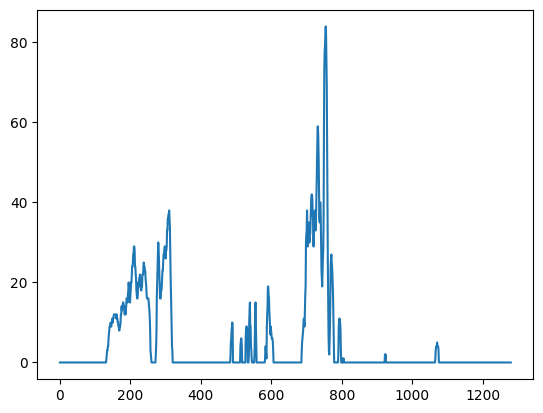

In [147]:
def find_histogram_peaks(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

    # Peak in the first half indicates the likely position of the left lane
    half_width = int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:half_width])

    # Peak in the second half indicates the likely position of the right lane
    rightx_base = np.argmax(histogram[half_width:]) + half_width
    
    return histogram, leftx_base, rightx_base

histogram, leftx_base, rightx_base = find_histogram_peaks(warped)

print(leftx_base, rightx_base)
plt.plot(histogram)

# plt.savefig('plot/plt1.jpg')

In [148]:
# 피크 개수를 세어 노이즈 감지

Is histogram noisy? False


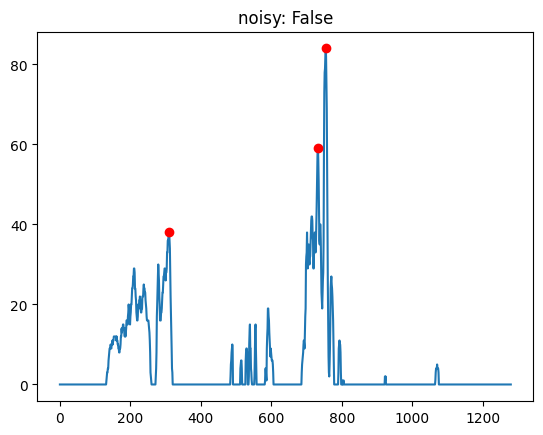

In [149]:
from scipy.signal import find_peaks
from scipy.signal import peak_prominences


def detect_noisy(histogram, min_prominence=30, avg_value_threshold=20, zero_count_threshold=300, return_peaks=False):
    # Detect peaks in the histogram
    peaks, _ = find_peaks(histogram)
    
    # Calculate the prominence of the detected peaks
    prominences = peak_prominences(histogram, peaks)[0]
    
    # Filter peaks based on prominence
    filtered_peaks = peaks[prominences > min_prominence]
    
    is_noisy = False
    
    # If there are at least two peaks, check the average value criterion
    if len(filtered_peaks) >= 2:
        left_peak_idx = filtered_peaks[0]
        right_peak_idx = filtered_peaks[-1]
        
        # Calculate the average value between the two peaks
        avg_value = np.mean(histogram[left_peak_idx:right_peak_idx])
        # print(avg_value)
        
        # Check if the average value exceeds the threshold
        if avg_value > avg_value_threshold:
            is_noisy = True

        # Calculate the count of zero values between the two peaks
        zero_count = np.sum(histogram[left_peak_idx:right_peak_idx] < 10)
        # print(zero_count)
        
        # Check if the zero count exceeds the threshold
        if zero_count > zero_count_threshold:
            is_noisy = False  # It's not noisy if there are more than 300 zero values
    if return_peaks:
        return filtered_peaks, is_noisy
    
    return is_noisy


histogram, _, _ = find_histogram_peaks(warped)
peaks, is_noisy = detect_noisy(histogram, return_peaks=True)

print("Is histogram noisy?", is_noisy)
plt.title(f'noisy: {is_noisy}')
plt.plot(histogram)
for peak in peaks:
    plt.plot(peak, histogram[peak], "ro")  # Plot detected peaks as red circles
plt.savefig('plot/plt2.jpg')
plt.show()


### Sliding Window Search
I then perform a sliding window search, starting with the base likely positions of the 2 lanes, calculated from the histogram. I have used 10 windows of width 100 pixels.

The x & y coordinates of non zeros pixels are found, a polynomial is fit for these coordinates and the lane lines are drawn.

In [150]:
def detect_lines(img, return_img=False):
    # Take a histogram of the bottom half of the image
    
    histogram, leftx_base, rightx_base = find_histogram_peaks(img)

    if return_img:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((img, img, img))*255

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = int(img.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])   
    nonzeroy = np.array(nonzero[0])
   

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if return_img:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # If line is not detected
    if lefty.size == 0:
        lefty = np.array([10, 10])
    if leftx.size == 0:
        leftx = np.array([10, 10])
    if righty.size == 0:
        righty = np.array([10, 10])
    if rightx.size == 0:
        rightx = np.array([10, 10])

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
###########################
    # 여기부터는
    # 탐지된 두 차선의 간격을 계산하고 이상값이 있다면
    # 탐지를 건너 뛰도록 하는 부분이다
    
    # x값들의 차를 계산하여 두 점 사이의 거리들을 구함
    differences = right_fitx - left_fitx
    
    # 계산한 두 점사이의 거리 평균 계산
    average_distance = np.mean(differences)
    # print('min', min(differences))
    # print('max', max(differences))
    # print('avg', average_distance)
    
    # 평균과 최소값, 평균과 최대값이 차를 구하고 절대값으로 변환
    min_diff_from_avg = abs(min(differences) - average_distance)
    max_diff_from_avg = abs(max(differences) - average_distance)

    # min/max와 평균값의 차이 허용 임계값
    diff_threshold = 300

    # 평균값이 400과 600사이에 있지 않은가
    criteria1 = not (400 <= average_distance <= 600)
    # min/max와 평균값의 차이가 diff_threshold 이상인가
    criteria2 = min_diff_from_avg > diff_threshold or max_diff_from_avg > diff_threshold

    # if criteria1 or criteria2:
    #     lefty = np.array([10, 10])
    #     leftx = np.array([10, 10])
    #     righty = np.array([10, 10])
    #     rightx = np.array([10, 10])
        
    #      # Fit a second order polynomial to each
    #     left_fit = np.polyfit(lefty, leftx, 2)
    #     right_fit = np.polyfit(righty, rightx, 2)
        
    #     ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    #     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # if criteria1:
    #     print("average is not between 400 and 600")
    # if criteria2:
    #     print("Line detection failed due to large differences from average.")

    #########################
    if return_img:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Draw left and right lines
        for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
            
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img

    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)

True

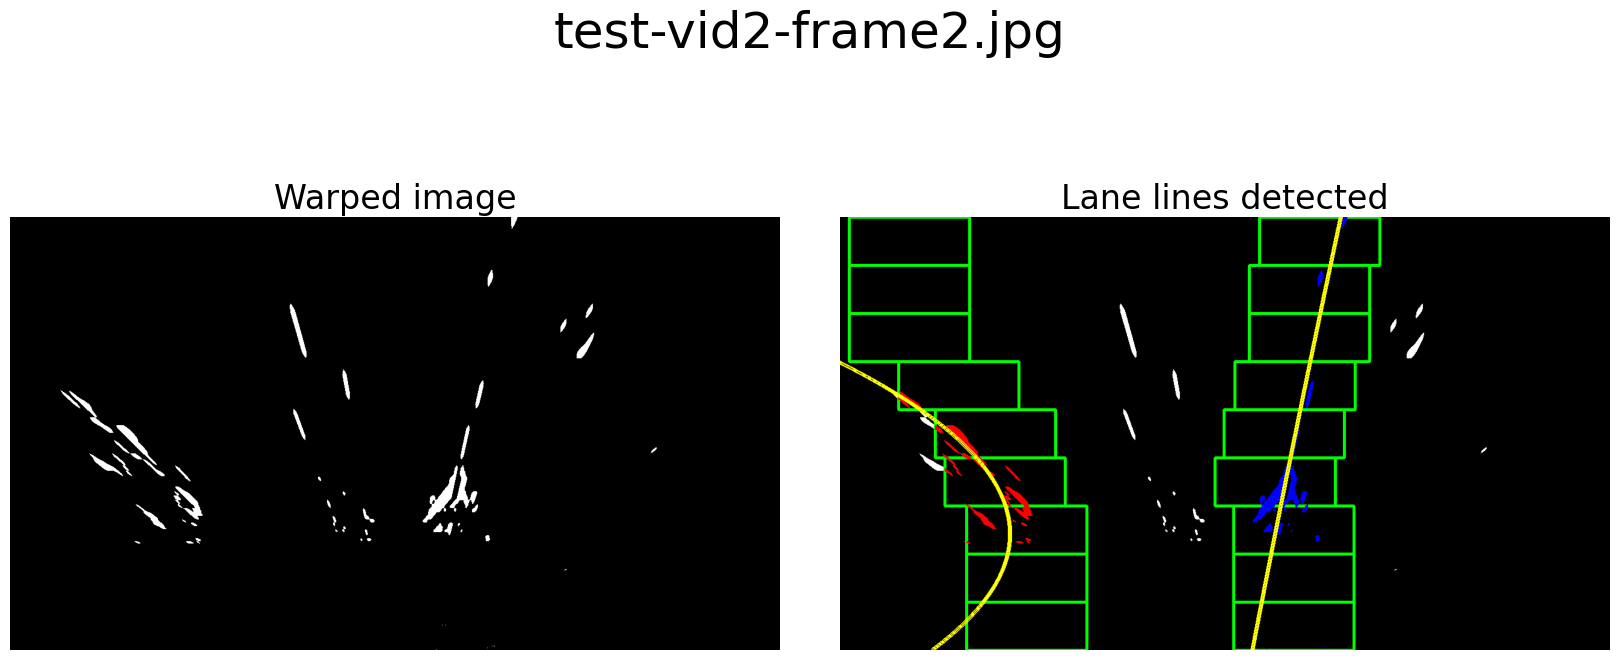

In [151]:
# Run the function
lines_fit, left_points, right_points, out_img = detect_lines(warped, return_img=True)

# Plot the result
imgs = [warped, out_img]
names = ['Warped image' ,'Lane lines detected']
plot_result(imgs, names, 1, 2)

warped2 = cv2.cvtColor(warped, cv2.COLOR_RGB2BGR)
cv2.imwrite('plot/detect1.jpg', warped2 * 255)
out_img2 = cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('plot/detect2.jpg', out_img2)

### Searching around a previously detected line.
Since consecutive frames are likely to have lane lines in roughly similar positions, in this section we search around a margin of 100 pixels of the previously detected lane lines.

In [152]:
def get_averaged_line(previous_lines, new_line):
    '''
        This function computes an averaged lane line by averaging over previous good frames.
    '''
    
    # Number of frames to average over
    num_frames = 12
    
    if new_line is None:
        # No line was detected
        
        if len(previous_lines) == 0:
            # If there are no previous lines, return None
            return previous_lines, None
        else:
            # Else return the last line
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            # we need at least num_frames frames to average over
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            # average over the last num_frames frames
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line

def detect_similar_lines(img, 
                         line_fits=None,
                         past_good_left_lines=[],
                         past_good_right_lines=[],
                         running_mean_difference_between_lines = 0,
                         return_img=False):
    # if line_fits is None:
    return detect_lines(img, return_img)
    
    
    left_fit = line_fits[0]
    right_fit = line_fits[1]
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # If any of the lines could not be found, 
    # perform a more exhaustive search
    if (leftx.size == 0 or rightx.size == 0):
        return detect_lines(img, return_img)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    
    # If no pixels were found return None
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    

    # Smoothing
    mean_difference = np.mean(right_fitx - left_fitx)
        
    if running_mean_difference_between_lines == 0:
        running_mean_difference_between_lines = mean_difference
        
    if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
        if len(past_good_left_lines) == 0 and len(past_good_right_lines) == 0:
            return detect_lines(img, return_img)
        else:
            left_fitx = past_good_left_lines[-1]
            right_fitx = past_good_right_lines[-1]
    else:
        past_good_left_lines, left_fitx = get_averaged_line(past_good_left_lines, left_fitx)
        past_good_right_lines, right_fitx = get_averaged_line(past_good_right_lines, right_fitx)
        mean_difference = np.mean(right_fitx - left_fitx)
        running_mean_difference_between_lines = 0.9*running_mean_difference_between_lines + 0.1*mean_difference
  
        
    if return_img:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((img, img, img))*255
        window_img = np.zeros_like(out_img)

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
     
        for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
    
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img
    
    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)

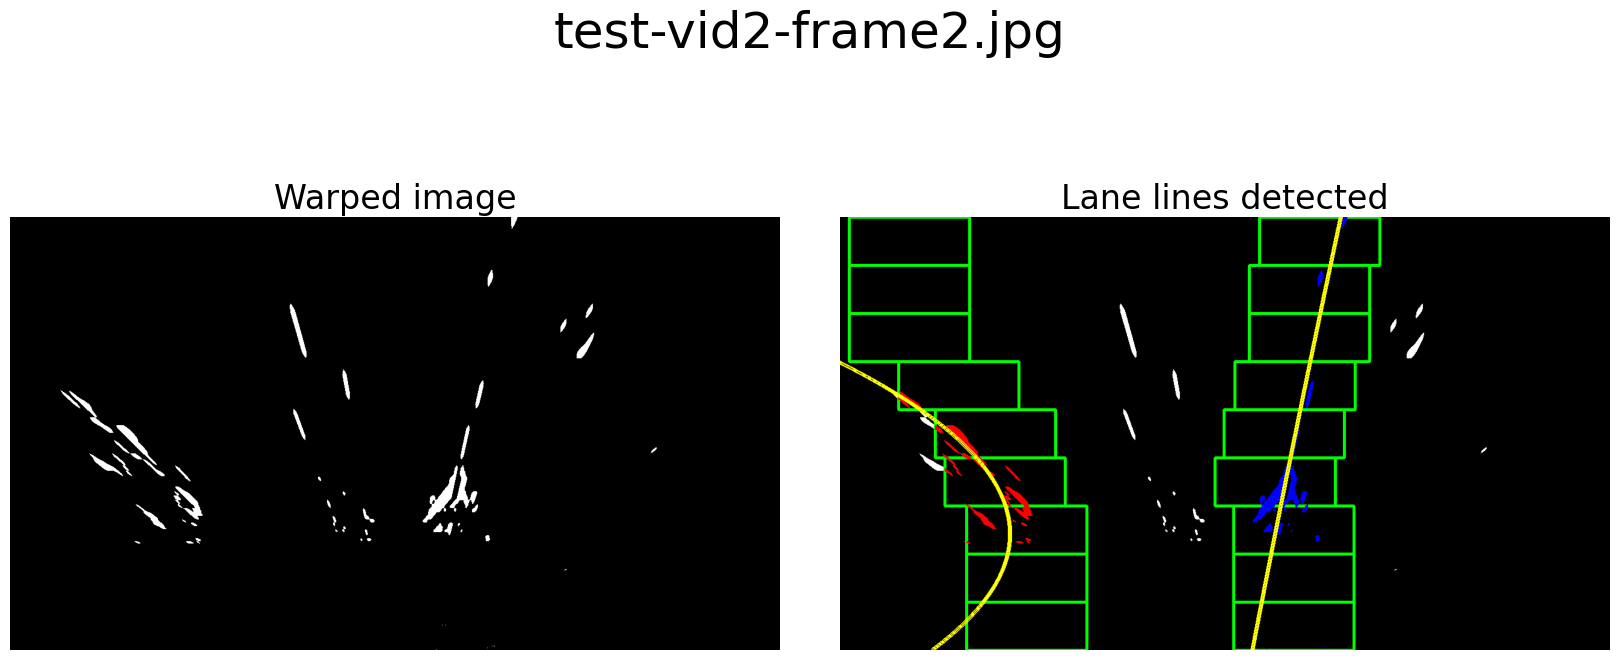

In [153]:
# Run the function
# Notice I am passing the same image than before.
# In a video stream, it should be passed the next frame.
lines_fit, left_points, right_points, out_img = detect_similar_lines(warped, lines_fit, return_img=True)

# Plot the result
imgs = [warped, out_img]
names = ['Warped image' ,'Lane lines detected']
plot_result(imgs, names, 1, 2)


## 6. Determine the curvature of the lane and vehicle position with respect to center.
### Computing the radius of curvature and center offset.
The radius of curvature is computed according to the formula and method described in the classroom material. Since we perform the polynomial fit in pixels and whereas the curvature has to be calculated in real world meters, we have to use a pixel to meter transformation and recompute the fit again.

The mean of the lane pixels closest to the car gives us the center of the lane. The center of the image gives us the position of the car. The difference between the 2 is the offset from the center.

In [154]:
# y: 720픽셀당 40미터

def curvature_radius (leftx, rightx, img_shape, xm_per_pix=3.7/800, ym_per_pix = 25/720):
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)

In [155]:
# STEP 8: CALCULATE OFFSET DISTANCE AND ROAD CURVATURE

# Run the function
curvature_rads = curvature_radius(leftx=left_points[0], rightx=right_points[0], img_shape = image.shape)

# Print the results
print('Left line curvature:', curvature_rads[0], 'm')
print('Right line curvature:', curvature_rads[1], 'm')

Left line curvature: 51.64637314717691 m
Right line curvature: 8439.350120237395 m


In [156]:
def car_offset(leftx, rightx, img_shape, xm_per_pix=1/153.3):
    ## Image mid horizontal position 
    mid_imgx = img_shape[1]//2
        
    ## Car position with respect to the lane
    car_pos = (leftx[-1] + rightx[-1])/2
    
    ## Horizontal car offset 
    offsetx = (mid_imgx - car_pos) * xm_per_pix

    return offsetx

In [157]:
# Run the function
offsetx = car_offset(leftx=left_points[0], rightx=right_points[0], img_shape=image.shape)

print ('Car offset from center:', offsetx, 'm.')

Car offset from center: 1.4352390593341307 m.


## 7. Warp the detected lane boundaries back onto the original image.
### Inverse Transform
In this block of code we:

Paint the lane area
Perform an inverse perspective transform
Combine the precessed image with the original image.

In [158]:
# STEP 7: UNWARP OVERLAY FROM TOP-DOWN VIEW BACK INTO CAMERA VIEW
def draw_lane(img, warped_img, left_points, right_points, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    #########################
    # histogram, _, _ = find_histogram_peaks(warped_img)
    
    # # 히스토그램에 노이즈가 많은가
    # is_noisy = detect_noisy(histogram)
    
    
    # if is_noisy:
    #     cv2.fillPoly(color_warp, np.int_([pts]), (255,255, 0))
    # else:
    #     cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    #########################

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    cv2.imwrite('plot/img1.jpg', color_warp)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    cv2.imwrite('plot/img2.jpg', newwarp)

    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

True

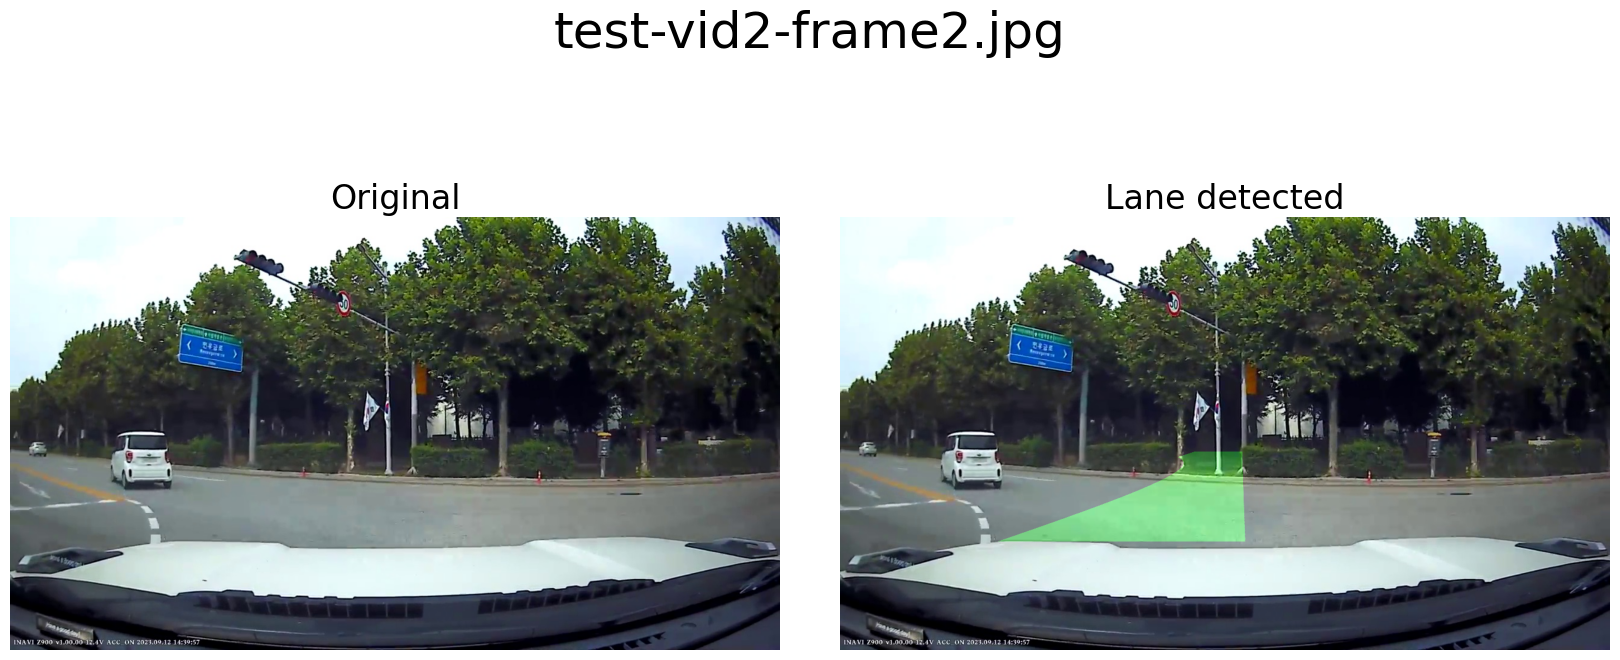

In [159]:
# Run the function
img_lane = draw_lane(image, warped, left_points, right_points, Minv)

# Plot the result
imgs = [image, img_lane]
names = ['Original' ,'Lane detected']
plot_result(imgs, names, 1, 2)

img_lane2 = cv2.cvtColor(img_lane, cv2.COLOR_RGB2BGR)
cv2.imwrite('plot/img3.jpg', img_lane2)

## 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [104]:
def add_metrics(img, leftx, rightx, xm_per_pix=3.7/800, ym_per_pix = 25/720):    
    # Calculate radius of curvature
    # curvature_rads = curvature_radius(leftx=leftx, rightx=rightx, img_shape=img.shape,
    #                                   xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix)
    # Calculate car offset
    offsetx = car_offset(leftx=leftx, rightx=rightx, img_shape=img.shape)

    # Display lane curvature
    out_img = img.copy()
    # cv2.putText(out_img, 'Left lane line curvature: {:.2f} m'.format(curvature_rads[0]), 
    #             (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    # cv2.putText(out_img, 'Right lane line curvature: {:.2f} m'.format(curvature_rads[1]), 
    #             (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    # Display car offset
    if offsetx > 0:
        cv2.putText(out_img, 'right: {:.2f} m'.format(abs(offsetx)), 
                (500, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,0,0), 5)
    else:
        cv2.putText(out_img, 'left: {:.2f} m'.format(abs(offsetx)), 
                (500, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,0,0), 5)
    
    
    return out_img

True

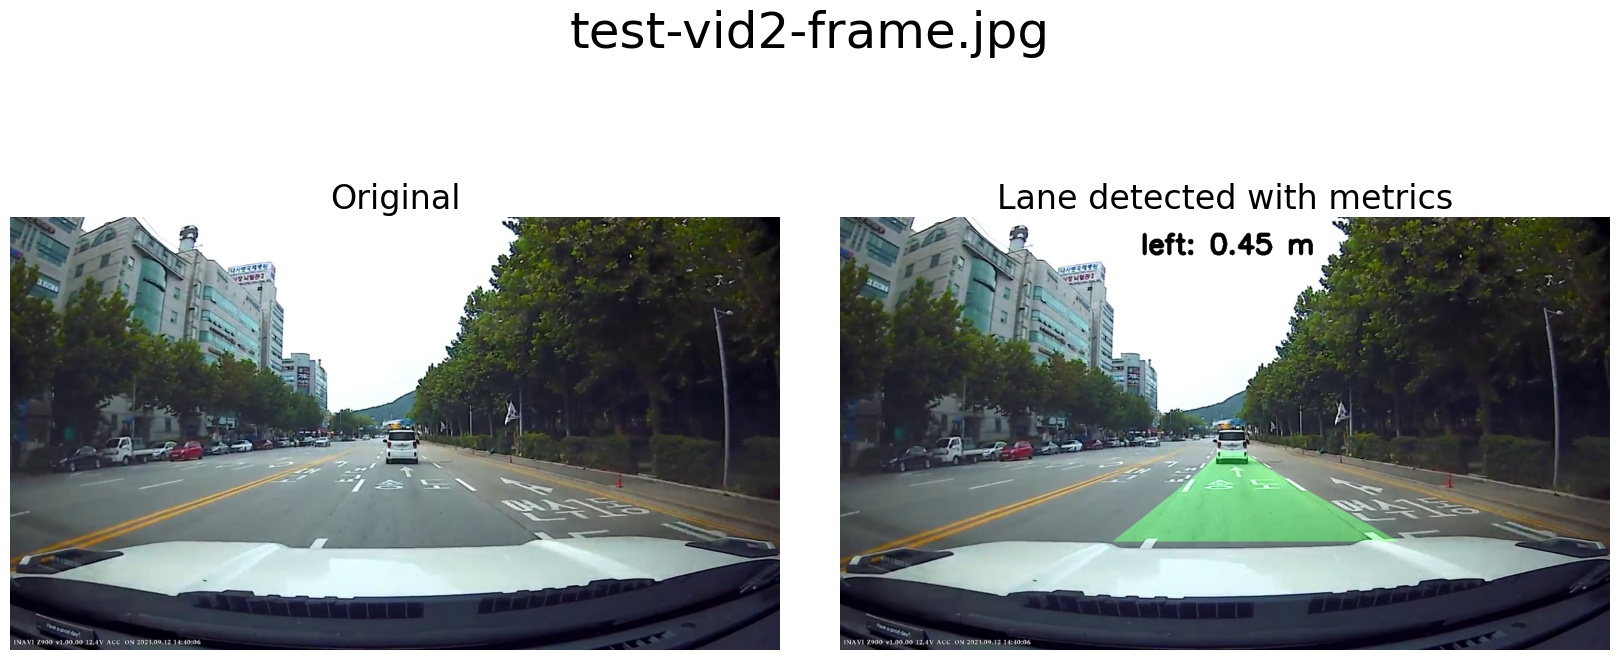

In [105]:
# Run the function
out_img = add_metrics(img_lane, leftx=left_points[0], rightx=right_points[0])

# Plot the result
imgs = [image, out_img]
names = ['Original' ,'Lane detected with metrics']
plot_result(imgs, names, 1, 2)

out_img2 = cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('plot/img4.jpg', out_img2)

## Step 9: Run pipeline in a video.

In [106]:
def detect_green(result_img):
    """Detect green regions from the result image."""
    # Convert image to HSV color space
    hsv = cv2.cvtColor(result_img, cv2.COLOR_BGR2HSV)

    # Define range for green color
    lower_green = np.array([40, 40, 40])
    upper_green = np.array([90, 255, 255])

    # Create mask for green color
    mask = cv2.inRange(hsv, lower_green, upper_green)

    return mask

def detect_red(result_img):
    """Detect red regions from the result image."""
    # Convert image to HSV color space
    hsv = cv2.cvtColor(result_img, cv2.COLOR_BGR2HSV)

    # Define range for red color
    # Red in HSV can be in two ranges due to wrapping around 0
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])
    
    lower_red2 = np.array([160, 100, 100])
    upper_red2 = np.array([180, 255, 255])

    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)

    # Combine the two masks to get a complete mask for red
    mask = cv2.bitwise_or(mask1, mask2)

    return mask


def mask_green_box(original_img, result_img):
    """Detect green region from result image and mask it in the original image."""
    green_mask = detect_green(result_img)
    
    # Find the contour of the green area
    contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return original_img
    
    # Assuming the largest contour corresponds to the lane, get its bounding box
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Create a black mask with the size of the original image
    mask = np.zeros_like(green_mask)
    
    # Draw the bounding box as a white rectangle on the black mask
    mask[y:y+h, x:x+w] = 255

    # Extract the box region's corresponding area from the original image
    box_region = cv2.bitwise_and(original_img, original_img, mask=mask)

    return box_region

def mask_red_box(original_img, result_img):
    """Detect red region from result image and mask it in the original image."""
    red_mask = detect_red(result_img)
    
    # Find the contour of the red area
    contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return original_img
    
    # Assuming the largest contour corresponds to the lane, get its bounding box
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Create a black mask with the size of the original image
    mask = np.zeros_like(red_mask)
    
    # Draw the bounding box as a white rectangle on the black mask
    mask[y:y+h, x:x+w] = 255

    # Extract the box region's corresponding area from the original image
    box_region = cv2.bitwise_and(original_img, original_img, mask=mask)

    return box_region


In [107]:
class Pipeline:
    def __init__(self, cal_path):
        # Make a list of calibration images

        # Calibrate camera
        self.mtx, self.dist = camera_calibration(cal_path)
        
        # Reinitialize 
        self.lines_fit = None
        self.past_good_left_lines = []
        self.past_good_right_lines = []
        self.running_mean_difference_between_lines = 0

    def __call__(self, img):
        
        # STEP 1: UNDISTORT (using camera calibration step matrix and dist)
        undistorted = undistort_image(img, self.mtx, self.dist)
        
        # STEP 2: GAUSSIAN BLUR
        blurred = gaussian_blur(undistorted, kernel=3)

        # STEP 3: APPLY COLOR SPACE TRANSFORM AND SOBEL THRESHOLDING
        combined = get_thresholded_image(blurred)
        
        # Apply a perspective transform to rectify binary image ("birds-eye view")
        # src_coordinates = np.float32(
        #     [[280,  700],  # Bottom left
        #      [595,  460],  # Top left
        #      [725,  460],  # Top right
        #      [1125, 700]]) # Bottom right
    #     src_coordinates = np.float32(
    # [[385, 540],  # Bottom left
    #  [618, 390],  # Top left
    #  [685, 390],  # Top right
    #  [918, 540]]) # Bottom right
        src_coordinates = np.float32(
        [[335, 540],  # Bottom left
         [612, 390],  # Top left
         [691, 390],  # Top right
         [968, 540]]) # Bottom right

        dst_coordinates = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right   

        # STEP 4: WARP BINARY IMAGE INTO TOP-DOWN VIEW
        warped, M, Minv = warp(combined, src_coordinates, dst_coordinates)
        
        
        # STEP 5: Detect lane pixels and fit to find the lane boundary
        self.lines_fit, left_points, right_points, out_img = detect_similar_lines(warped, 
                                                                                  self.lines_fit, 
                                                                                  self.past_good_left_lines,
                                                                                  self.past_good_right_lines,
                                                                                  self.running_mean_difference_between_lines,
                                                                                  return_img=True,)

        # STEP 6: Warp the detected lane boundaries back onto the original image.
        img_lane = draw_lane(img, warped, left_points, right_points, Minv)
            
        # STEP 7: Add metrics to the output img
        out_img = add_metrics(img_lane, leftx=left_points[0], rightx=right_points[0])
            
        return out_img

In [108]:
from PIL import Image
from keras.models import load_model


model = load_model('full_CNN_model.h5')


class Pipeline2():
    def __init__(self):
        self.recent_fit = []
        self.avg_fit = []

    def process(self, image):
        """ Takes in a road image, crops it 200px above the bottom and 300px from both sides, re-sizes for the model,
        predicts the lane to be drawn from the model in RED color,
        recreates an RGB image of a lane and merges with the
        original road image. A red line is drawn at 200px above the bottom.
        """
        
        # Crop the image to 200px above the bottom and 300px from both sides
        cropped_image = image[:-50, 300:-300]
        
        # Convert cropped image to PIL for resizing
        cropped_image_pil = Image.fromarray(np.uint8(cropped_image))
        cropped_image_resized = cropped_image_pil.resize((160, 80))
        small_img = np.array(cropped_image_resized)
        small_img = small_img[None,:,:,:]
        
        # Make prediction with neural network (un-normalize value by multiplying by 255)
        prediction = model.predict(small_img)[0] * 255
        
        # Add lane prediction to list for averaging
        self.recent_fit.append(prediction)
        # Only using last five for average
        if len(self.recent_fit) > 5:
            self.recent_fit = self.recent_fit[1:]
        
        # Calculate average detection
        self.avg_fit = np.mean(np.array([i for i in self.recent_fit]), axis=0)
        
        # Generate fake G & B color dimensions, stack with R
        blanks = np.zeros_like(self.avg_fit).astype(np.uint8)
        lane_drawn = np.dstack((blanks, blanks, self.avg_fit))
        
        # Re-size to match the cropped image size
        lane_image_pil = Image.fromarray(np.uint8(lane_drawn))
        lane_image_resized = lane_image_pil.resize(cropped_image.shape[1::-1])  # Get width and height from cropped image
        lane_image = np.array(lane_image_resized)
        
        # Merge the predicted lane with the cropped image
        combined_cropped = cv2.addWeighted(cropped_image, 1, lane_image, 1, 0)
        
        # Replace pixels in the region of interest with combined_cropped pixels
        result = image.copy()
        height_of_cropped = combined_cropped.shape[0]
        result[-height_of_cropped-50:-50, 300:-300] = combined_cropped
        
        # Draw a red line 200px above the bottom of the result image
        cv2.line(result, (300, result.shape[0]-50), (result.shape[1]-300, result.shape[0]-50), (0, 0, 255), 2)
        
        return result



In [ ]:
class EnsemblePipeline():
    def __init__(self, cal_path):
        self.pipeline1 = Pipeline(cal_path)
        self.pipeline2 = Pipeline2()

    def __call__(self, image):
        result_img = self.pipeline2.process(image)
        focused_img = mask_red_box(image, result_img)
        second_result = self.pipeline1(focused_img)

        # ensemble_result = np.maximum(img1, img2)
        return second_result

In [ ]:
def apply_video2(input_video, output_video):

    # Process video frames with our 'process_image' function
    process_image = EnsemblePipeline('./camera_cal/*.jpg')
    
    ## You may uncomment the following line for a subclip of the first 5 seconds
    #clip1 = VideoFileClip(input_video).subclip(0,5)
    clip1 = VideoFileClip(input_video)
    white_clip = clip1.fl_image(process_image)
    %time white_clip.write_videofile(output_video, audio=False)
    
    print("Apply video pipeline: SUCCESS!")

In [ ]:
test_image = 'test-vid2-frame.jpg'
img = mpimg.imread(test_image)

pipe = Pipeline2()
pipe2 = Pipeline('./camera_cal/*.jpg')
result_img = pipe.process(img)
focused_img = mask_red_box(img, result_img)
cv2.imwrite('keras_mask_result1.jpg', result_img)
cv2.imwrite('keras_mask_result2.jpg', focused_img)
img1 = pipe2(focused_img)
cv2.imwrite('keras_mask_result3.jpg', img1)

In [ ]:
input_video = 'test-vid.mp4'
output_video = 'test-vid-output3.mp4'

apply_video2(input_video, output_video)

## Example Result
We apply the pipeline to a test image. The original image and the processed image are shown side by side.

In [57]:
test_image = 'test-vid2-frame.jpg'
# test_image = 'test_images/test2.jpg'
img = mpimg.imread(test_image)

# Process video frames with our 'process_image' function
process_image = Pipeline('./camera_cal/*.jpg')

# Apply pipeline
processed = process_image(img)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

NameError: name 'Pipeline' is not defined

In [ ]:
def apply_video(input_video, output_video):

    # Process video frames with our 'process_image' function
    process_image = Pipeline('./camera_cal/*.jpg')
    
    ## You may uncomment the following line for a subclip of the first 5 seconds
    #clip1 = VideoFileClip(input_video).subclip(0,5)
    clip1 = VideoFileClip(input_video)
    white_clip = clip1.fl_image(process_image)
    %time white_clip.write_videofile(output_video, audio=False)
    
    print("Apply video pipeline: SUCCESS!")

In [ ]:
input_video = 'test-vid.mp4'
output_video = 'test-vid-output.mp4'

apply_video(input_video, output_video)

In [ ]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))


# Discussion
## Issues and Challenges
---
### Figuring out bad frames
There will be some frames where no lanes will be detected or the lanes might not make sense. We determine the bad frames if any of the following conditions are met:

1. No pixels were detected using the sliding window search or search around the previously detected line.
2. The average gap between the lanes is less than 0.7 times pr greater than 1.3 times the globally maintained moving average of the lane gap.

### Averaging lanes
The lane for each frame is a simple average of 12 previously computed lanes. This is done in the get_averaged_line method in the code block below.

### What to do if a bad frame is detected?
1. Perform a sliding window search again (this is done in the detect_lines function)
2. If this still results in a bad frame then we fall back to the previous well detected frame.

### Final Pipeline
We combine all the code described in the code block above, plus the averaging and fallback techniques described in this block. The final code is in the Pipeline class.